# Hosted Notebooks in ArcGIS Enterprise / ArcGIS Online

This notebook will step you through a few aspects of working with hosted ArcGIS Notebooks within an ArcGIS Enterprise or ArcGIS Online portal.  In order to use hosted ArcGIS Notebooks, your ArcGIS Enterprise portal must be configured with a federated instance of Notebook Server that is licensed and configured to host advanced ArcGIS Notebooks, or your ArcGIS Online account must have permission to use advanced ArcGIS Notebooks (currently in beta).

Starting a new notebook is as simple clicking the 'Notebook' a link in the main menu of the ArcGIS Online or Enterprise web interface.  When you do this, you are initially provided with a simple template that contains one code cell pre-populated with two lines of code.  The first line imports the `arcgis` library's `GIS()` function for connection to your online/enterprise GIS, and the second executes it with `"home"` specified as the URL.  This parameter is a signal for the `GIS()` function to connect using the same portal and credentials that you are using to access the currently-running notebook:

In [1]:
from arcgis.gis import GIS
gis = GIS("home")

/opt/conda/lib/python3.11/site-packages/arcgis/gis/__init__.py:731: UserWarning: You are logged on as ssattar_edu with an administrator role, proceed with caution.
  warnings.warn(


> Note: if you are running this notebook using a local Jupyter Notebook server, this connection will not work (because you're not currently logged into any online GIS portal!).  
> 
> If this applies to you, you must replace the arguments to the `GIS()` function to connect your GIS with the correct URL and credentials in order to proceed.

Next, import the modules you will be using in this notebook.

> Note that you are still able to import the `arcpy` module!  This requires the ability to host *Advanced* notebooks in your GIS portal.  Advanced ArcGIS Notebooks give you access to the full capabilities of both ArcGIS Online/ArcGIS Enterprise with the `arcgis` module (that you can use in virtually *any* Python 3 environment) combined with the powerful geoprocessing framework with `arcpy` that you normally get with ArcGIS Pro on your desktop, all from a simple web browser interface!

In [2]:
import arcpy
import os
import pandas as pd
from arcgis.geoenrichment import get_countries, enrich, Country
from zipfile import ZipFile, ZIP_DEFLATED

## Prepare 'Local' Files in a Hosted Notebook

When performing analysis in a hosted notebook, ideally you will be able to access your GIS data as items alrady published to your ArcGIS Online or ArcGIS Enterprise systems (e.g., as hosted feature layers, big data stores, image services).  However, in some cases, you may need to access source data as simple files.  You can still do this in a hosted ArcGIS Notebook, but you must upload your data to the file system used by the Notebook.

1. Click the `Files` button at the top of the web ArcGIS Notebook web interface (not the `File` dropdown menu)
1. In the panel that opens on the left, navigate into the 'home' folder
1. Upload a copy of the data prepared in the previous notebook in ArcGIS Pro (the zipped archive: `notebook_basics/data/toronto/MCI.gdb.zip`) (after clicking the Upload button, you may need to wait for a minute or two, depending on your Internet connection speed).
1. When the file upload has has completed, you should see the zip archive appear as an item in the files pannel.

Once the file is uploaded, you will need to unzip it so that you can read the contents of the file geodatabase, just as you would when executing `arcpy` commands on your own computer.

Execute the code cell below - here you will define a variable that stores the `/arcgis/home` file path as string, and two additional variables to specify paths for the uploaded zip file and for the resulting file geodatabase that will be extracted.  The `ZipFile` object is used to extract the contents of the uploaded zip file, and then two additional path variables are defined that point to the `mci_points` and `mci_hotspots` feature classes contained in the file geodatabase:

In [3]:
home_dir = '/arcgis/home'
mci_zip = os.path.join(home_dir, 'MCI.gdb.zip')
mci_gdb = os.path.join(home_dir, 'MCI.gdb')

# # Uncomment to restart from scratch
# if arcpy.Exists(mci_gdb):
#     arcpy.management.Delete(mci_gdb)

with ZipFile(mci_zip) as z:
    z.extractall(home_dir)
    
mci_points = os.path.join(mci_gdb, 'Major_Crime_Indicators_local')
mci_hotspots = os.path.join(mci_gdb, 'MCI_hotspots')

With what you learned in the analysis completed in the previous notebook in this tutorial using ArcGIS Pro, you know that the results of the emerging hot spot analysis tool aren't telling you much more than you likely already know (i.e., that there are more crimes in more densely populated areas in the downtown core of the City of Toronto, and generally fewer crimes in less densely populated areas).

Execute the next code cell to load the hotspots layer into a spatially enabled data frame, and review the attributes for a sample of records:

In [4]:
mci_hotspots_sdf = pd.DataFrame.spatial.from_featureclass(mci_hotspots)
mci_hotspots_sdf.head()

,OBJECTID,LOCATION,CATEGORY,PATTERN,PERC_HOT,PERC_COLD,TREND_Z,TREND_P,TREND_BIN,SUM_VALUE,MIN_VALUE,MAX_VALUE,MEAN_VALUE,STD_VALUE,MED_VALUE,SHAPE
0,1,232,0,No Pattern Detected,0.0,5.555556,-0.114485,0.908853,0,13,0,3,0.722222,0.989139,0.0,"{""rings"": [[[-8822316.4548, 5440563.268299997]..."
1,2,233,0,No Pattern Detected,0.0,0.0,-0.266228,0.790063,0,7,0,2,0.388889,0.590564,0.0,"{""rings"": [[[-8821883.4421, 5440813.268299997]..."
2,3,236,0,No Pattern Detected,0.0,5.555556,1.215579,0.224145,0,6,0,3,0.333333,0.816497,0.0,"{""rings"": [[[-8820584.404, 5440563.268299997],..."
3,4,237,0,No Pattern Detected,0.0,11.111111,0.228361,0.819366,0,6,0,3,0.333333,0.745356,0.0,"{""rings"": [[[-8820151.3913, 5440813.268299997]..."
4,5,361,-6,Sporadic Cold Spot,0.0,44.444444,-0.608963,0.542549,0,24,0,6,1.333333,1.414214,1.0,"{""rings"": [[[-8824048.5056, 5440063.268299997]..."


## Use GeoEnrichment to Add Population Totals

When you executed the emerging hot spot analysis tool, you used the 'COUNT' value from the space-time cube as the analysis variable.  As a result, the `SUM_VALUE` you see in the attributes above represents the total number of crimes reported within each hexagon bin over the 2014 to 2019 time period.

It would be helpful to normalize this total based on population density.  You can use the `arcgis.geoenrichment` module to access the ArcGIS Online geoenrichment service to add demographic data to hexagon bins.  For this example, you only need total population.

For this part of the analysis, you *must* be connected to a gis instance that is authenticated with ArcGIS Online using an account with access to service credits and sufficicent permissions to use the geoenrichment service.  

> *If you are using runing this notebook using ArcGIS Enterprise, you can create a separate connection object, as in the following code cell to connect to ArcGIS Online, or any other Enterprise portal with different credentials.*

Edit the credentials below (you may change the line to `ago = GIS("home")` if you are running this notebook in ArcGIS Online with an account that has access to GeoEnrichment to create the `ago` connection object used in subsequent code cells):

In [6]:
ago = GIS('https://www.arcgis.com', 'User_Name', set_active=True)

Enter password: ········


Lookup available datasets for Canada from the geoenrichment service (using the [get_countries()](https://developers.arcgis.com/python/api-reference/arcgis.geoenrichment.html#arcgis.geoenrichment.get_countries) method of the geoenrichment module):

In [7]:
countries_list = get_countries(gis=ago)
countries_list[countries_list['name'] == 'Canada']['datasets']

31    [CAN_ESRI_2023, CAN_CPY_2023, CAN_DATAAXLE_202...
Name: datasets, dtype: object

Check the current dataset for Canada:

In [9]:
# Get Canada country object
canada = Country.get('CAN', gis=ago)
canada.dataset

'CAN_ESRI_2023'

List available data collections:

In [10]:
canada.data_collections.index.unique()

Index(['Age', 'AgeOfImmigration', 'AverageIncomeChangeConstant',
       'AverageIncomeChangeCurrent', 'AverageIncomeTrendConstant',
       'AverageIncomeTrendCurrent', 'basicFactsForMobileApps', 'Basics',
       'CASpendingFacts', 'ChildrenAtHome', 'CitizenshipAndAge',
       'ClassOfWorker', 'Clothing', 'CondominiumStatus', 'DaytimePopulation',
       'Education', 'EducationalAttainment', 'FiveYearAgeAndSex',
       'FiveYearPopulationTotals', 'Food', 'FurnishingsAndEquipment',
       'GamesOfChanceNet', 'GenerationStatus', 'GiftsOfMoneyAndContributions',
       'GoodsServicesPurchased', 'HealthPersonalCare', 'HomeLanguage',
       'HouseholdChange', 'HouseholdIncAfterTaxCensusYear',
       'HouseholdIncomeConstantYear', 'HouseholdIncomeCurrentYear',
       'HouseholdOperation', 'HouseholdPopulationByAge',
       'HouseholdPopulationByAgeSex', 'HouseholdPopulationChange',
       'HouseholdPopulationTrend', 'HouseholdTrend', 'HouseholdType',
       'ImmigrationPlaceOfBirth', 'IncomeCha

List variables from the `KeyGlobalFacts` collection:

In [11]:
canada.data_collections.loc['KeyGlobalFacts']['analysisVariable'].unique()

array(['KeyGlobalFacts.TOTPOP', 'KeyGlobalFacts.TOTHH',
       'KeyGlobalFacts.AVGHHSZ', 'KeyGlobalFacts.TOTMALES',
       'KeyGlobalFacts.TOTFEMALES'], dtype=object)

Enrich the hexagon bins from the emerging hot spot analysis with the total population variable.  The results of the `enrich()` function will be returned as a spatially enabled data frame.

> Note: this will require significant time, and will consume approximately 46 credits to add a variable to all 46,000 hexagon bins in the mci_hotspots_layer using the ArcGIS geoenrichment service.  If you do not want to wait, and/or do not have service credits available, you can skip this step, and instead load a pre-enriched copy of the layer from `/arcgis/home/MCI.gdb/mci_hotspots_enriched` into a spatially enabled data frame.  To do so, comment-out the first line of code with the `enrich()` function (add `#` at the start), and uncomment the last line (remove the initial `#` character) in the code cell below to load the mci_hotspots_enriched layer already provided in the sample MCI geodatabase:

In [12]:
# use the enrich function (if you have credits)
mci_hotspots_enriched = canada.enrich(mci_hotspots_sdf, analysis_variables=["KeyGlobalFacts.TOTPOP"])

# or load from the pre-enriched copy of the featureclass
#mci_hotspots_enriched = pd.DataFrame.spatial.from_featureclass(os.path.join(mci_gdb, 'mci_hotspots_enriched'))

/opt/conda/lib/python3.11/site-packages/arcgis/features/geo/_accessor.py:1531: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data[col] = array
/opt/conda/lib/python3.11/site-packages/arcgis/features/geo/_accessor.py:1531: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data[col] = array
/opt/conda/lib/python3.11/site-packages/arcgis/features/geo/_accessor.py:1531: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Execute the next cell to save the spatially enabled data frame as a new feature class in your file geodatabase (e.g., so you can re-use your geoenriched features at any later time):

In [13]:
mci_hotspots_enriched.spatial.to_featureclass(os.path.join(mci_gdb, 'mci_hotspots_enriched'), overwrite=True)

'/arcgis/home/MCI.gdb/mci_hotspots_enriched'

## Calculate a New Crime Rate Attribute for Optimized Hot Spot Analysis

Now that you have enriched the data with total population for each hexagon bin, you can caculate a new attribute that represents the proportional crime rate for the 2014-2019 period relative to the total population assigned to the area by the geoenrichment service: 

In [14]:
mci_hotspots_enriched["crime_rate"] = mci_hotspots_enriched["sum_value"] / mci_hotspots_enriched["totpop"]
mci_hotspots_enriched.head()

,objectid,location,category,pattern,perc_hot,perc_cold,trend_z,trend_p,trend_bin,sum_value,...,population_to_polygon_size_rating,apportionment_confidence,has_data,totpop,tothh,avghhsz,totmales,totfemales,SHAPE,crime_rate
0,1,232,0,No Pattern Detected,0.0,5.555556,-0.114485,0.908853,0,13,...,-1.0,-1.0,1,631.0,164.0,3.64,312.0,319.0,"{""rings"": [[[-8822316.4548, 5440563.268299997]...",0.020602
1,2,233,0,No Pattern Detected,0.0,0.0,-0.266228,0.790063,0,7,...,-1.0,-1.0,1,1091.0,255.0,4.04,540.0,551.0,"{""rings"": [[[-8821883.4421, 5440813.268299997]...",0.006416
2,3,236,0,No Pattern Detected,0.0,5.555556,1.215579,0.224145,0,6,...,-1.0,-1.0,1,344.0,81.0,4.0,171.0,173.0,"{""rings"": [[[-8820584.404, 5440563.268299997],...",0.017442
3,4,237,0,No Pattern Detected,0.0,11.111111,0.228361,0.819366,0,6,...,-1.0,-1.0,1,401.0,92.0,4.09,198.0,203.0,"{""rings"": [[[-8820151.3913, 5440813.268299997]...",0.014963
4,5,361,-6,Sporadic Cold Spot,0.0,44.444444,-0.608963,0.542549,0,24,...,-1.0,-1.0,1,508.0,128.0,3.71,248.0,260.0,"{""rings"": [[[-8824048.5056, 5440063.268299997]...",0.047244


You can see that there are a number of 'inf' values in the new `crime_rate` column (the right-most column table preview displayed above).  These are areas that have greater than zero crimes from 2014 to 2019, but were assigned zero population from the geoenrichment service.  These areas represent about 10% of the entire set 4.6k bins - you can see this by filtering the data frame to include only rows with an infinite value for the `crime_rate` column, and comparing its shape to the overall data frame:

In [15]:
mci_hotspots_enriched[mci_hotspots_enriched["crime_rate"] == float('Inf')].shape

(428, 27)

In [16]:
mci_hotspots_enriched.shape

(4395, 27)

You will exclude these rows from further analyis, leaving about 4.1k bins that represent areas with greater than zero popuplation assigned to them by the enrichment process:

In [17]:
mci_hotspots_enriched_nozeropop = mci_hotspots_enriched[mci_hotspots_enriched["crime_rate"] != float('Inf')].copy()
mci_hotspots_enriched_nozeropop.shape

(3967, 27)

Next, save the non-zero population bins to a new feature layer, and execute the Optimized Hot Spot Analysis tool to look for hotspots based on the new `CRIME_RATE` attribute you calculated. Note that is executing an analysis tool provided by the `arcpy` geoprocessing framework.  This analysis could be executed in an ArcGIS Pro project on a desktop PC.  However, with access to *advanced* hosted ArcGIS Notebooks, you can perform the same analyses from any computer or device without any ArcGIS software installed by using the integrated Jupyter web interface:

In [18]:
mci_crime_rates_fc = os.path.join(mci_gdb, 'mci_crime_rates')
mci_crime_rates_ohsa_fc = os.path.join(mci_gdb, 'mci_crime_rates_ohsa')

mci_hotspots_enriched_nozeropop.spatial.to_featureclass(mci_crime_rates_fc, overwrite=True)

if arcpy.Exists(mci_crime_rates_ohsa_fc):
    arcpy.management.Delete(mci_crime_rates_ohsa_fc)

arcpy.stats.OptimizedHotSpotAnalysis(
    Input_Features=mci_crime_rates_fc,
    Output_Features=mci_crime_rates_ohsa_fc,
    Analysis_Field="crime_rate"
)


************************** Initial Data Assessment ***************************
Making sure there are enough weighted features for analysis....
    - There are 3967 valid input features.

Evaluating the Analysis Field values....
    - CRIME_RATE Properties:
        Min:       0.0008
        Max:       6.0000
        Mean:      0.0503
        Std. Dev.: 0.2091
Looking for locational outliers....
    - There were 18 outlier locations; these will not be used to compute the optimal fixed distance band.

***************************** Scale of Analysis ******************************
Looking for an optimal scale of analysis by assessing the intensity of clustering at increasing distances....
    - The optimal fixed distance band is based on peak clustering found at 1501.0000 meters

***************************** Hot Spot Analysis ******************************
Finding statistically significant clusters of high and low crime_rate values....
    - There are 143 output features statistically sig

<Result '/arcgis/home/MCI.gdb/mci_crime_rates_ohsa'>

Make sure our home gis portal is set as the active portal (e.g., if you're working in ArcGIS Enterprise, the connection to ArcGIS Online established earlier for GeoEnrichment is currently your default connection), and then publish the analysis output as a new feature layer:

In [19]:
gis = GIS("home", set_active=True)

mci_crime_rates_ohsa_sdf = pd.DataFrame.spatial.from_featureclass(mci_crime_rates_ohsa_fc)
mci_crime_rates_ohsa_layer = mci_crime_rates_ohsa_sdf.spatial.to_featurelayer("mci_crime_rates_ohsa", gis, "OHSA")

/opt/conda/lib/python3.11/site-packages/arcgis/gis/__init__.py:731: UserWarning: You are logged on as ssattar_edu with an administrator role, proceed with caution.
  warnings.warn(


## Display Analysis Results

Now that you have completed your analysis, visualize the results in a map within the notebook.  You can plot features with a renderer that will emphasize signifcant hot spots (reds) and significant cold spots (the renderer properties in the code below correspond to the JSON defintion of a class breaks renderer for an [ArcGIS web map](https://developers.arcgis.com/web-map-specification/objects/classBreaksRenderer/) (more examples here in the ArcGIS API for Python [guide](https://developers.arcgis.com/python/guide/advanced-cartography-part1/)):

In [20]:
ohsa_map = gis.map("Toronto, ON")

ohsa_layer = mci_crime_rates_ohsa_layer.layers[0]

outline = {"type":"esriSLS","color":[153,153,153,64],"width":0.375,"style":"esriSLSSolid"}
    
ohsa_map.add_layer(ohsa_layer, {
    "renderer": {
        "type":"classBreaks",
        "classBreakInfos":[{
            "label":"Cold >= 99%",
            "classMaxValue":-2.9,
            "symbol":{"type":"esriSFS","color":[0,0,255,255],"outline":outline,"style":"esriSFSSolid"}
        },{
            "label":"Cold >= 95%",
            "classMaxValue":-1.9,
            "symbol":{"type":"esriSFS","color":[100,100,255,255],"outline":outline,"style":"esriSFSSolid"}
        },{
            "label":"Cold >= 90%",
            "classMaxValue":-0.9,
            "symbol":{"type":"esriSFS","color":[200,200,255,200],"outline":outline,"style":"esriSFSSolid"}
        },{
            "label":"Insignificant",
            "classMaxValue":0.9,
            "symbol":{"type":"esriSFS","color":[255,255,255,200],"outline":outline,"style":"esriSFSSolid"}
        },{
            "label":"Hot >= 90%",
            "classMaxValue":1.9,
            "symbol":{"type":"esriSFS","color":[255,200,200,200],"outline":outline,"style":"esriSFSSolid"}
        },{
            "label":"Hot >= 95%",
            "classMaxValue":2.9,
            "symbol":{"type":"esriSFS","color":[255,100,100,200],"outline":outline,"style":"esriSFSSolid"}
        },{
            "label":"Hot >= 99%",
            "classMaxValue":4,
            "symbol":{"type":"esriSFS","color":[255,0,0,200],"outline":outline,"style":"esriSFSSolid"}
        }],
        "field":"Gi_Bin",
        "minValue":-4
    }
})

ohsa_map

# from IPython.display import Image
# Image('/arcgis/home/ohsa.png')

MapView(layout=Layout(height='400px', width='100%'))

In contrast with the emerging hot spot analyis results you examined in the previous notebook for this tutorial, you can see in the map above that there is a very different pattern emerging from examining crime rates normalized by population using the optimized hotspot analysis tool.  There are no longer notable cold spots detected.  The hot spot cluster in the downtown core, while still present, is far less dominating. Several previously undetected clusters of hotspots have also been detected in the northwest and western regions of the city.  Analysis results like these could help decision makers when planning how to address changing patterns in crime.  For example, the hotspots identified here may be serve as the focus for more in depth study on the causes and possible methods for mitigating crime in these neighbourhoods.

These data can may be refined for much more in-depth investigation of crime patterns in Toronto. For example, the analyis thus far has not yet taken into addtional properties of the crime data that could provide much more useful insight, such as the types of offences involved in the reported crimes, or different temporal patterns in the reported crimes (e.g., seasonal, diurnal, weekly).  Using geoenrichment, other socio-economic variables could also be added to further examine their relationship with reported crime rates.

## Adding Items to Hosted Notebooks

Accessing data from an ArcGIS Enterprise portal, ArcGIS Online, or the *Living Atlas of the World* is made easy with the addtional controls provided by the hosted ArcGIS Notebook web interace.  For example, although you already have a reference to the newly published layer in your portal (i.e., the result returned by the `to_featurelayer()` function excuted above), you can easily insert code that loads this item into a new variable in any hosted notebook session by performing the following steps:

Try this by performing the following steps:
* Click the `Add` button near the top left of the web interface.
* In the panel that appears to the left, you should see your own content items displayed.  If appropriate, reposition the cell by clicking the up/down arrow buttons in the notebook toolbar.
* Click the `+` icon to the bottom-right of the new `mci_crime_rates_ohsa` layer that you published.
* A code cell will be inserted that will load the item into your current python session.  By default, the item will be assigned to a variable named `item`, but typically you will want to rename this.  Change the variable name to `ohsa_layer`, and execute the code cell.

The result of the steps above should produce a result similar to the following code cell:

<Item title:"mci_crime_rates_ohsa" type:Feature Layer Collection owner:ssattar_edu>
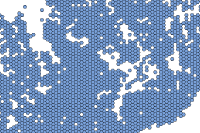

In [21]:
# Item Added From Toolbar
# Title: mci_crime_rates_ohsa | Type: Feature Service | Owner: ssattar_edu
ohsa_layer = gis.content.get("94410ebba4254421b51be19c5ff32f37")
ohsa_layer

Try repeating the steps above, but search instead for 'toronto neighbourhoods' in ArcGIS Online (click 'My Content' at the top, and choose 'ArcGIS Online').  You should be able to find the 'Toronto_Neigbourhoods' feature layer published by EsriCanadaEducation to your code.  Insert a code cell for this layer by clicking its `+` button, rename the variable for this item to `neighbourhoods`, and execute the code cell:

<Item title:"Toronto_Neighbourhoods" type:Feature Layer Collection owner:EsriCanadaEducation>
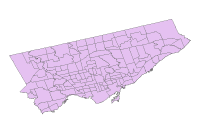

In [22]:
# Item Added From Toolbar
# Title: Toronto_Neighbourhoods | Type: Feature Service | Owner: EsriCanadaEducation
neighbourhoods = gis.content.get("5fa0e4d94e3147b1b957b0d84641c7a1")
neighbourhoods

The following steps will execute an analysis function to aggregate the points from Toronto Police Service's 'MCI' layer, and the neighbourhoods layer loaded above.  Because of the large number of features this dataset contains (~206k), you will need to have these data published as a hosted layer in your own content.

Below is a code snippet that you can use to filter the crime points to those with valid neighbourhoods and longitude/latitude coordinates, and publish the local copy of the mci_points feature class in the file geodatabase to a new hosted feature layer in your content, and save the resulting item as a variable named `mci_points_layer`.  

> **Note**: this is not required to complete this notebook if you plan to skip executing the aggregate points analysis in the following steps.  If you wish to proceed with these steps, uncomment and execute the two lines in the following code cell.  Publishing the layer may take a few minutes to complete, depending on your Internet connection:

In [23]:
mci_points_sdf = pd.DataFrame.spatial.from_featureclass(mci_points)
mci_points_sdf = mci_points_sdf[(mci_points_sdf.NEIGHBOURHOOD_158 != "NSA") & (mci_points_sdf.LONG_WGS84 != 0) & (mci_points_sdf.LAT_WGS84 != 0)]
mci_points_layer = mci_points_sdf.spatial.to_featurelayer('mci_points_layer', gis=gis)

## Adding Analysis Functions

Just like adding datasets, you can insert snippets of code that access the various analysis services enabled by your ArcGIS Enterprise or ArcGIS Online systems.  For example, if you wanted use the Aggregate Points analysis tool to summarize the number of crimes that have occurred from 2014 to 2019 within each Toronto neighbourhood, you can use the following steps:

1. Click the `Analysis` button near the top left of the hosted ArcGIS Notebook web interface
1. Expand the `Summarize Data` category of tools within the Standard tab
1. Click the `+` icon to the right of that tool to insert a new code cell that contains the required import statment, and copy of the corresponding function call from the `arcgis` library.
1. At this point, the function has not been supplied with any arguments, and it is now up to you to fill these in.
    * Place your cursor within the `()` parentheses at the end of the function, and press SHIFT+Tab to display the documentation for the function in a tooltip.
    > Note: if you do not see the documentation appear, comment out the second line in the code cell by placing a `#` character at the start (do not comment-out the `import` statement).  Execute the code cell once to ensure the required module is loaded in your current session.  Now remove the `#` character from the second line to uncomment it, and try accessing the function documentation again with the `SHIFT+Tab` keystroke. 
    * The documentation should reveal the arguments you need to supply to the analysis function for it to work.
    * For the `aggregate_points` function in this case, at a minimum you must provide a point layer and polygon layer in order to perform the aggregate analysis.
    * If you want the results to be created as a new hosted feature layer in ArcGIS Online or ArcGIS Enterprise, you must specify the `output_name` parameter.  Otherwise, you must capture the result of the function in a variable, which will be returned as a spatially enabled data frame.
    > **Note**: Analysis functions in ArcGIS Online require service credits to be executed.  Be sure to review the [online documenation](https://doc.arcgis.com/en/arcgis-online/administer/credits.htm#ESRI_SECTION1_709121D2C7694DCAB9B8592F36F7A5BA) to understand the credits that will be required to conduct your analyses.  If you do not have sufficient credits, but you do have access to an ArcGIS Enterprise instance, you can connect to your Enterprise gis, and supply that connection object for the optional `gis` argument. The Toronto Police Service MCI data contains approximately ~206,000 point features, and therefore will require 206 credits to use the `aggregate_points` tool when executed with an ArcGIS Online connection.  
    
    > **Note**: It is not necessary to perform this analysis to complete this notebook - a pre-processed copy of the output can be found in `/arcgis/home/MCI.gdb/neighbourhood_agg`.
    
1. If you choose to execute the `aggregate_points()` function, specify the MCI points as the point layer, the Toronto neighbourhoods as polygon layer, specify `neighbourhood_agg` as the `output_name` parameter, and save the function output to a variable named `agg_result`, as follows:

```python
from arcgis import features
agg_result = features.summarize_data.aggregate_points(mci_points_layer, neighbourhoods, output_name="neighbourhood_agg", gis=gis)
```

<Item title:"neighbourhood_agg" type:Feature Layer Collection owner:ssattar_edu>
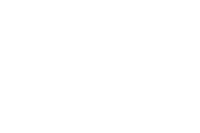

In [24]:
# Item Added From Toolbar
# Title: neighbourhood_agg | Type: Feature Service | Owner: mleahy_edu
agg_result = gis.content.get("21dc0db69f874e65876c2b7b20e712b3")
agg_result

In [25]:
agg_map = gis.map("Toronto, ON")
agg_map.add_layer(agg_result)
agg_map

# from IPython.display import Image
# Image('/arcgis/home/agg.png')

MapView(layout=Layout(height='400px', width='100%'))

To save the result to a local feature class in the 'MCI.gdb' for later re-use, execute the following code cell to create a variable that points to a path to a new feature class in your file geodatabse, and use the spatial extension on the `neighbourhood_agg_sdf` spatially enabled data frame to write its contents to that path:

In [26]:
neighbourhood_agg_fc = os.path.join(mci_gdb, 'neighbourhood_agg')

if not os.path.exists(neighbourhood_agg_fc):
    neighbourhood_agg_sdf = pd.DataFrame.spatial.from_layer(agg_result.layers[0])
    neighbourhood_agg_sdf.spatial.to_featureclass(neighbourhood_agg_fc, overwrite=True)

## Package Files for Download

If you have files associated with the hosted notebook that you want to retain (e.g., the results of the analysis saved to the file geodatabase in this notebook), you can download them individually from the `Files` panel in the hosted ArcGIS Notebook web interface. In the case of a file geodatabase, this isn't ideal (as it contains many individual files).  Instead, you might choose to zip the file geodatabase into a single archive using the `zipfile` library, demonstrated in the code cell below.  Once the archive is ready, you can download it from the ArcGIS Notebook web interface, or perhaps publish it as a new data item in your GIS portal (i.e., using the `arcgis` library).

In [27]:
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipdir(mci_gdb, ZipFile('/arcgis/home/MCI.gdb.nb.zip', 'w', ZIP_DEFLATED))